# Installs

In [1]:
!pip install --upgrade open_spiel

Requirement already up-to-date: open_spiel in /home/bhandk/.local/lib/python3.8/site-packages (1.2)


In [2]:
!pip install torch==1.11.0+cu102 torchvision==0.12.0+cu102 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu102
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu102.html
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cpu.html

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu102
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu102.html


# Reinforcement Learning Class

## RL Environment

In [3]:
# Copyright 2019 DeepMind Technologies Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Reinforcement Learning (RL) Environment for Open Spiel.

This module wraps Open Spiel Python interface providing an RL-friendly API. It
covers both turn-based and simultaneous move games. Interactions between agents
and the underlying game occur mostly through the `reset` and `step` methods,
which return a `TimeStep` structure (see its docstrings for more info).

The following example illustrates the interaction dynamics. Consider a 2-player
Kuhn Poker (turn-based game). Agents have access to the `observations` (a dict)
field from `TimeSpec`, containing the following members:
 * `info_state`: list containing the game information state for each player. The
   size of the list always correspond to the number of players. E.g.:
   [[0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]].
 * `legal_actions`: list containing legal action ID lists (one for each player).
   E.g.: [[0, 1], [0]], which corresponds to actions 0 and 1 being valid for
   player 0 (the 1st player) and action 0 being valid for player 1 (2nd player).
 * `current_player`: zero-based integer representing the player to make a move.

At each `step` call, the environment expects a singleton list with the action
(as it's a turn-based game), e.g.: [1]. This (zero-based) action must correspond
to the player specified at `current_player`. The game (which is at decision
node) will process the action and take as many steps necessary to cover chance
nodes, halting at a new decision or final node. Finally, a new `TimeStep`is
returned to the agent.

Simultaneous-move games follow analogous dynamics. The only differences is the
environment expects a list of actions, one per player. Note the `current_player`
field is "irrelevant" here, admitting a constant value defined in spiel.h, which
defaults to -2 (module level constant `SIMULTANEOUS_PLAYER_ID`).

See open_spiel/python/examples/rl_example.py for example usages.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections

import enum
from absl import logging
import numpy as np

import pyspiel

SIMULTANEOUS_PLAYER_ID = pyspiel.PlayerId.SIMULTANEOUS

class TimeStep(
    collections.namedtuple(
        "TimeStep", ["observations", "rewards", "discounts", "step_type"])):
  """Returned with every call to `step` and `reset`.

  A `TimeStep` contains the data emitted by a game at each step of interaction.
  A `TimeStep` holds an `observation` (list of dicts, one per player),
  associated lists of `rewards`, `discounts` and a `step_type`.

  The first `TimeStep` in a sequence will have `StepType.FIRST`. The final
  `TimeStep` will have `StepType.LAST`. All other `TimeStep`s in a sequence will
  have `StepType.MID.

  Attributes:
    observations: a list of dicts containing observations per player.
    rewards: A list of scalars (one per player), or `None` if `step_type` is
      `StepType.FIRST`, i.e. at the start of a sequence.
    discounts: A list of discount values in the range `[0, 1]` (one per player),
      or `None` if `step_type` is `StepType.FIRST`.
    step_type: A `StepType` enum value.
  """
  __slots__ = ()

  def first(self):
    return self.step_type == StepType.FIRST

  def mid(self):
    return self.step_type == StepType.MID

  def last(self):
    return self.step_type == StepType.LAST

  def is_simultaneous_move(self):
    return self.observations["current_player"] == SIMULTANEOUS_PLAYER_ID

  def current_player(self):
    return self.observations["current_player"]


class StepType(enum.Enum):
  """Defines the status of a `TimeStep` within a sequence."""

  FIRST = 0  # Denotes the first `TimeStep` in a sequence.
  MID = 1  # Denotes any `TimeStep` in a sequence that is not FIRST or LAST.
  LAST = 2  # Denotes the last `TimeStep` in a sequence.

  def first(self):
    return self is StepType.FIRST

  def mid(self):
    return self is StepType.MID

  def last(self):
    return self is StepType.LAST


# Global pyspiel members
def registered_games():
  return pyspiel.registered_games()



class ChanceEventSampler(object):
  """Default sampler for external chance events."""

  def __init__(self, seed=None):
    self.seed(seed)

  def seed(self, seed=None):
    self._rng = np.random.RandomState(seed)

  def __call__(self, state):
    """Sample a chance event in the given state."""
    actions, probs = zip(*state.chance_outcomes())
    return self._rng.choice(actions, p=probs)


class ObservationType(enum.Enum):
  """Defines what kind of observation to use."""
  OBSERVATION = 0  # Use observation_tensor
  INFORMATION_STATE = 1  # Use information_state_tensor


class Environment(object):
  """Open Spiel reinforcement learning environment class."""

  def __init__(self,
               game,
               discount=1.0,
               chance_event_sampler=None,
               observation_type=None,
               include_full_state=False,
               distribution=None,
               mfg_population=None,
               enable_legality_check=False,
               **kwargs):
    """Constructor.

    Args:
      game: [string, pyspiel.Game] Open Spiel game name or game instance.
      discount: float, discount used in non-initial steps. Defaults to 1.0.
      chance_event_sampler: optional object with `sample_external_events` method
        to sample chance events.
      observation_type: what kind of observation to use. If not specified, will
        default to INFORMATION_STATE unless the game doesn't provide it.
      include_full_state: whether or not to include the full serialized
        OpenSpiel state in the observations (sometimes useful for debugging).
      distribution: the distribution over states if the game is a mean field
        game.
      mfg_population: The Mean Field Game population to consider.
      enable_legality_check: Check the legality of the move before stepping.
      **kwargs: dict, additional settings passed to the Open Spiel game.
    """
    self._chance_event_sampler = chance_event_sampler or ChanceEventSampler()
    self._include_full_state = include_full_state
    self._distribution = distribution
    self._mfg_population = mfg_population
    self._enable_legality_check = enable_legality_check

    if isinstance(game, str):
      if kwargs:
        game_settings = {key: val for (key, val) in kwargs.items()}
        logging.info("Using game settings: %s", game_settings)
        self._game = pyspiel.load_game(game, game_settings)
      else:
        logging.info("Using game string: %s", game)
        self._game = pyspiel.load_game(game)
    else:  # pyspiel.Game or API-compatible object.
      logging.info("Using game instance: %s", game.get_type().short_name)
      self._game = game

    self._num_players = self._game.num_players()
    self._state = None
    self._should_reset = True

    # Discount returned at non-initial  steps.
    self._discounts = [discount] * self._num_players

    # Determine what observation type to use.
    if observation_type is None:
      if self._game.get_type().provides_information_state_tensor:
        observation_type = ObservationType.INFORMATION_STATE
      else:
        observation_type = ObservationType.OBSERVATION

    # Check the requested observation type is supported.
    if observation_type == ObservationType.OBSERVATION:
      if not self._game.get_type().provides_observation_tensor:
        raise ValueError(f"observation_tensor not supported by {game}")
    elif observation_type == ObservationType.INFORMATION_STATE:
      if not self._game.get_type().provides_information_state_tensor:
        raise ValueError(f"information_state_tensor not supported by {game}")
    self._use_observation = (observation_type == ObservationType.OBSERVATION)

    if self._game.get_type().dynamics == pyspiel.GameType.Dynamics.MEAN_FIELD:
      assert distribution is not None
      assert mfg_population is not None
      assert 0 <= mfg_population < self._num_players

  def seed(self, seed=None):
    self._chance_event_sampler.seed(seed)

  def get_time_step(self):
    """Returns a `TimeStep` without updating the environment.

    Returns:
      A `TimeStep` namedtuple containing:
        observation: list of dicts containing one observations per player, each
          corresponding to `observation_spec()`.
        reward: list of rewards at this timestep, or None if step_type is
          `StepType.FIRST`.
        discount: list of discounts in the range [0, 1], or None if step_type is
          `StepType.FIRST`.
        step_type: A `StepType` value.
    """
    observations = {
        "num_nodes":[],
        "info_state": [],
        "global_feature": [],
        "legal_actions": [],
        "current_player": [],
        "serialized_state": []
    }
    rewards = []
    step_type = StepType.LAST if self._state.is_terminal() else StepType.MID
    self._should_reset = step_type == StepType.LAST
    cur_rewards = self._state.rewards()
    for player_id in range(self.num_players):
      rewards.append(cur_rewards[player_id])
      observations["info_state"].append(self._state.info_state)
      '''observations["info_state"].append(
          self._state.observation_tensor(player_id) if self._use_observation
          else self._state.information_state_tensor(player_id))'''
      observations["legal_actions"].append(self._state.legal_actions(player_id))
    observations["num_nodes"] = self._state.num_nodes
    observations["global_feature"] = self._state.global_feature
    observations["current_player"] = self._state.current_player()
    discounts = self._discounts
    if step_type == StepType.LAST:
      # When the game is in a terminal state set the discount to 0.
      discounts = [0. for _ in discounts]

    if self._include_full_state:
      observations["serialized_state"] = pyspiel.serialize_game_and_state(
          self._game, self._state)

    return TimeStep(
        observations=observations,
        rewards=rewards,
        discounts=discounts,
        step_type=step_type)

  def _check_legality(self, actions):
    if self.is_turn_based:
      legal_actions = self._state.legal_actions()
      if actions[0] not in legal_actions:
        raise RuntimeError(f"step() called on illegal action {actions[0]}")
    else:
      for p in range(len(actions)):
        legal_actions = self._state.legal_actions(p)
        if legal_actions and actions[p] not in legal_actions:
          raise RuntimeError(f"step() by player {p} called on illegal " +
                             f"action: {actions[p]}")

  def step(self, actions):
    """Updates the environment according to `actions` and returns a `TimeStep`.

    If the environment returned a `TimeStep` with `StepType.LAST` at the
    previous step, this call to `step` will start a new sequence and `actions`
    will be ignored.

    This method will also start a new sequence if called after the environment
    has been constructed and `reset` has not been called. Again, in this case
    `actions` will be ignored.

    Args:
      actions: a list containing one action per player, following specifications
        defined in `action_spec()`.

    Returns:
      A `TimeStep` namedtuple containing:
        observation: list of dicts containing one observations per player, each
          corresponding to `observation_spec()`.
        reward: list of rewards at this timestep, or None if step_type is
          `StepType.FIRST`.
        discount: list of discounts in the range [0, 1], or None if step_type is
          `StepType.FIRST`.
        step_type: A `StepType` value.
    """
    assert len(actions) == self.num_actions_per_step, (
        "Invalid number of actions! Expected {}".format(
            self.num_actions_per_step))
    if self._should_reset:
      return self.reset()

    if self._enable_legality_check:
      self._check_legality(actions)

    if self.is_turn_based:
      self._state.apply_action(actions[0])
    else:
      self._state.apply_actions(actions)
    self._sample_external_events()

    return self.get_time_step()

  def reset(self):
    """Starts a new sequence and returns the first `TimeStep` of this sequence.

    Returns:
      A `TimeStep` namedtuple containing:
        observations: list of dicts containing one observations per player, each
          corresponding to `observation_spec()`.
        rewards: list of rewards at this timestep, or None if step_type is
          `StepType.FIRST`.
        discounts: list of discounts in the range [0, 1], or None if step_type
          is `StepType.FIRST`.
        step_type: A `StepType` value.
    """
    self._should_reset = False
    if self._game.get_type(
    ).dynamics == pyspiel.GameType.Dynamics.MEAN_FIELD and self._num_players > 1:
      self._state = self._game.new_initial_state_for_population(
          self._mfg_population)
    else:
      self._state = self._game.new_initial_state()
    self._sample_external_events()

    observations = {
        "num_nodes":[],
        "info_state": [],
        "global_feature":[],
        "legal_actions": [],
        "current_player": [],
        "serialized_state": []
    }
    for player_id in range(self.num_players):
      observations["info_state"].append(self._state.info_state)
      '''observations["info_state"].append(
          self._state.observation_tensor(player_id) if self._use_observation
          else self._state.information_state_tensor(player_id))'''
      observations["legal_actions"].append(self._state.legal_actions(player_id))
    observations["num_nodes"]= self._state.num_nodes
    observations["global_feature"]= self._state.global_feature
    observations["current_player"] = self._state.current_player()
    if self._include_full_state:
      observations["serialized_state"] = pyspiel.serialize_game_and_state(
          self._game, self._state)
    return TimeStep(
        observations=observations,
        rewards=None,
        discounts=None,
        step_type=StepType.FIRST)

  def _sample_external_events(self):
    """Sample chance events until we get to a decision node."""
    while self._state.is_chance_node() or (self._state.current_player()
                                           == pyspiel.PlayerId.MEAN_FIELD):
      if self._state.is_chance_node():
        outcome = self._chance_event_sampler(self._state)
        self._state.apply_action(outcome)
      if self._state.current_player() == pyspiel.PlayerId.MEAN_FIELD:
        dist_to_register = self._state.distribution_support()
        dist = [
            self._distribution.value_str(str_state, default_value=0.0)
            for str_state in dist_to_register
        ]
        self._state.update_distribution(dist)

  def observation_spec(self):
    """Defines the observation per player provided by the environment.

    Each dict member will contain its expected structure and shape. E.g.: for
    Kuhn Poker {"info_state": (6,), "legal_actions": (2,), "current_player": (),
                "serialized_state": ()}

    Returns:
      A specification dict describing the observation fields and shapes.
    """
    return dict(
        info_state=(),
        num_nodes=(),
        global_feature=(),
        legal_actions=(self._game.num_distinct_actions(),),
        current_player=(),
        serialized_state=(),
    )

  def action_spec(self):
    """Defines per player action specifications.

    Specifications include action boundaries and their data type.
    E.g.: for Kuhn Poker {"num_actions": 2, "min": 0, "max":1, "dtype": int}

    Returns:
      A specification dict containing per player action properties.
    """
    return dict(
        num_actions=self._game.num_distinct_actions(),
        min=0,
        max=self._game.num_distinct_actions() - 1,
        dtype=int,
    )

  # Environment properties
  @property
  def use_observation(self):
    """Returns whether the environment is using the game's observation.

    If false, it is using the game's information state.
    """
    return self._use_observation

  # Game properties
  @property
  def name(self):
    return self._game.get_type().short_name

  @property
  def num_players(self):
    return self._game.num_players()

  @property
  def num_actions_per_step(self):
    return 1 if self.is_turn_based else self.num_players

  # New RL calls for more advanced use cases (e.g. search + RL).
  @property
  def is_turn_based(self):
    return ((self._game.get_type().dynamics
             == pyspiel.GameType.Dynamics.SEQUENTIAL) or
            (self._game.get_type().dynamics
             == pyspiel.GameType.Dynamics.MEAN_FIELD))

  @property
  def max_game_length(self):
    return self._game.max_game_length()

  @property
  def is_chance_node(self):
    return self._state.is_chance_node()

  @property
  def game(self):
    return self._game

  def set_state(self, new_state):
    """Updates the game state."""
    assert new_state.get_game() == self.game, (
        "State must have been created by the same game.")
    self._state = new_state

  @property
  def get_state(self):
    return self._state

## Replay Buffer

In [4]:
# Copyright 2019 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Replay buffer of fixed size with a FIFI replacement policy."""

import random


class ReplayBuffer(object):
  """ReplayBuffer of fixed size with a FIFO replacement policy.
  Stored transitions can be sampled uniformly.
  The underlying datastructure is a ring buffer, allowing 0(1) adding and
  sampling.
  """

  def __init__(self, replay_buffer_capacity):
    self._replay_buffer_capacity = replay_buffer_capacity
    self._data = []
    self._next_entry_index = 0

  def add(self, element):
    """Adds `element` to the buffer.
    If the buffer is full, the oldest element will be replaced.
    Args:
      element: data to be added to the buffer.
    """
    if len(self._data) < self._replay_buffer_capacity:
      self._data.append(element)
    else:
      self._data[self._next_entry_index] = element
      self._next_entry_index += 1
      self._next_entry_index %= self._replay_buffer_capacity

  def sample(self, num_samples):
    """Returns `num_samples` uniformly sampled from the buffer.
    Args:
      num_samples: `int`, number of samples to draw.
    Returns:
      An iterable over `num_samples` random elements of the buffer.
    Raises:
      ValueError: If there are less than `num_samples` elements in the buffer
    """
    if len(self._data) < num_samples:
      raise ValueError("{} elements could not be sampled from size {}".format(
          num_samples, len(self._data)))
    return random.sample(self._data, num_samples)

  def reset(self):
    """Resets the contents of the replay buffer."""
    self._data = []
    self._next_entry_index = 0

  def __len__(self):
    return len(self._data)

  def __iter__(self):
    return iter(self._data)

## DQN PyTorch

In [5]:
# Copyright 2019 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""DQN agent implemented in PyTorch."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import numpy as np
from scipy import sparse
from torch._C import dtype
import torch
from torch import nn
from torch_geometric import nn as gnn
from torch.nn import functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from torch.nn import Flatten, Linear
from torch_geometric.utils import convert

from open_spiel.python import rl_agent
#from open_spiel.python.utils.replay_buffer import ReplayBuffer

Transition = collections.namedtuple(
    "Transition", "info_state global_feature action reward next_info_state next_global_feature is_final_step legal_actions_mask")

ILLEGAL_ACTION_LOGITS_PENALTY = -1e9


class GraphNN(nn.Module):
  """A simple network built from nn.linear layers."""

  def __init__(self,
               feature_size,
               hidden_sizes,global_size):
    """Create the MLP.
    Args:
      input_size: (int) number of inputs
      hidden_sizes: (list) sizes (number of units) of each hidden layer
      output_size: (int) number of outputs
      activate_final: (bool) should final layer should include a ReLU
    """
    super(GraphNN, self).__init__()
    hidden_conv, hidden_global, hidden_final = hidden_sizes[0], hidden_sizes[1], hidden_sizes[2]
    
    #2 GAT layer
    self.conv1 = GATv2Conv(feature_size, hidden_conv[0],add_self_loops = True) 
    self.conv1bn = gnn.BatchNorm(hidden_conv[0])
    self.conv2 = GATv2Conv(hidden_conv[0],hidden_conv[1],add_self_loops = True) 
    self.conv2bn = gnn.BatchNorm(hidden_conv[1])
    
    #Global_Linear Layer
    self.linear_global1 = nn.Linear(global_size, hidden_global[0])
    self.linear_global2 = nn.Linear(hidden_global[0], hidden_global[1])
    
    
    #Join to Layer
    self.linear1 = nn.Linear(hidden_conv[-1]+hidden_global[-1],hidden_final[0])
    self.batchnorm1 = nn.BatchNorm1d(hidden_final[0])
    self.linear2 = nn.Linear(hidden_final[0], hidden_final[1])
    self.batchnorm2 = nn.BatchNorm1d(hidden_final[1])
    self.linear3 = nn.Linear(hidden_final[1], 1)
  
  def forward(self, node_feature, edge_index, global_x):
    x, edge_index = node_feature, edge_index
    #MLP for Global Features
    global_x = self.linear_global1(global_x)
    global_x = self.linear_global2(global_x)
    global_x = global_x.repeat(x.size()[0],1)
    
    #GAT Layer for Graphs
    x = F.relu(self.conv1(x, edge_index))
    x = self.conv1bn(x)
    x = F.relu(self.conv2(x, edge_index))
    x = self.conv2bn(x)
    
    #Combining Graph Feature Embedding and GAT Layer 
    x = F.relu(self.linear1(torch.hstack((x,global_x))))
    x = self.batchnorm1(x)
    x = F.relu(self.linear2(x))
    x = self.batchnorm2(x)
    x = F.relu(self.linear3(x))
    x = torch.softmax(x,dim=0)
    return x


class DQN(rl_agent.AbstractAgent):
  """DQN Agent implementation in PyTorch.
  See open_spiel/python/examples/breakthrough_dqn.py for an usage example.
  """

  def __init__(self,
               player_id,
               state_representation_size,
               global_feature_size,
               num_actions,
               hidden_layers_sizes=[[4,3],[5,3],[6,4,3]],
               output_layer_size =1,
               replay_buffer_capacity=10000,
               batch_size=128,
               replay_buffer_class=ReplayBuffer,
               learning_rate=0.001,
               power = 1.0,
               nsteps = 3,
               update_target_network_every=1000,
               learn_every=10,
               discount_factor=1.0,
               min_buffer_size_to_learn=1000,
               epsilon_start=1.0,
               epsilon_end=0.1,
               epsilon_decay_duration=int(1e6),
               optimizer_str="adam",
               loss_str="huber"):
    """Initialize the DQN agent."""

    # This call to locals() is used to store every argument used to initialize
    # the class instance, so it can be copied with no hyperparameter change.
    self._kwargs = locals()

    self.player_id = player_id
    self._num_actions = num_actions
    """if isinstance(hidden_layers_sizes, int):
      hidden_layers_sizes = [hidden_layers_sizes]"""
    self.num_feature = state_representation_size
    self.global_feature_size = global_feature_size
    self._layer_sizes = hidden_layers_sizes
    self._batch_size = batch_size
    self._update_target_network_every = update_target_network_every
    self._learn_every = learn_every
    self._min_buffer_size_to_learn = min_buffer_size_to_learn
    self._discount_factor = discount_factor
    self._epsilon_start = epsilon_start
    self._epsilon_end = epsilon_end
    self._epsilon_decay_duration = epsilon_decay_duration
    self.power = power
    self.n_steps =  nsteps
    self.nstep_buffer = []
    # TODO(author6) Allow for optional replay buffer config.
    if not isinstance(replay_buffer_capacity, int):
      raise ValueError("Replay buffer capacity not an integer.")
    self._replay_buffer = replay_buffer_class(replay_buffer_capacity)
    self._prev_timestep = None
    self._prev_action = None

    # Step counter to keep track of learning, eps decay and target network.
    self._step_counter = 0

    # Keep track of the last training loss achieved in an update step.
    self._last_loss_value = None

    # Create the Q-network instances
    self._q_network = GraphNN(state_representation_size, self._layer_sizes,self.global_feature_size) #num_actions

    self._target_q_network = GraphNN(state_representation_size, self._layer_sizes,self.global_feature_size)
    # Q network outputs approx single feature embedded value = approx q value for each Noder
    if loss_str == "mse":
      self.loss_class = F.mse_loss
    elif loss_str == "huber":
      self.loss_class = F.smooth_l1_loss
    else:
      raise ValueError("Not implemented, choose from 'mse', 'huber'.")

    if optimizer_str == "adam":
      self._optimizer = torch.optim.Adam(
          self._q_network.parameters(), lr=learning_rate)
    elif optimizer_str == "sgd":
      self._optimizer = torch.optim.SGD(
          self._q_network.parameters(), lr=learning_rate)
    else:
      raise ValueError("Not implemented, choose from 'adam' and 'sgd'.")

  def step(self, time_step, is_evaluation=False, add_transition_record=True):
    """Returns the action to be taken and updates the Q-network if needed.
    Args:
      time_step: an instance of rl_environment.TimeStep.
      is_evaluation: bool, whether this is a training or evaluation call.
      add_transition_record: Whether to add to the replay buffer on this step.
    Returns:
      A `rl_agent.StepOutput` containing the action probs and chosen action.
    """

    # Act step: don't act at terminal info states or if its not our turn.
    if (not time_step.last()) and (
        time_step.is_simultaneous_move() or
        self.player_id == time_step.current_player()):
      num_nodes = time_step.observations["num_nodes"]
      info_state = time_step.observations["info_state"][self.player_id]
      legal_actions = time_step.observations["legal_actions"][self.player_id]
      global_feature = time_step.observations["global_feature"]
      self.epsilon = self._get_epsilon(is_evaluation,power=self.power)
      action, probs = self._epsilon_greedy(num_nodes,info_state,global_feature, legal_actions, self.epsilon)
    else:
      action = None
      probs = []
    #if legal_actions <= 5
    # Don't mess up with the state during evaluation.
    if not is_evaluation:
      self._step_counter += 1

      if self._step_counter % self._learn_every == 0:
        self._last_loss_value = self.learn()

      if self._step_counter % self._update_target_network_every == 0:
        # state_dict method returns a dictionary containing a whole state of the
        # module.
        self._target_q_network.load_state_dict(self._q_network.state_dict())

      if self._prev_timestep and add_transition_record:
        # We may omit record adding here if it's done elsewhere.
        self.add_transition(self._prev_timestep, self._prev_action, time_step)

      if time_step.last():  # prepare for the next episode.
        self._prev_timestep = None
        self._prev_action = None
        return
      else:
        self._prev_timestep = time_step
        self._prev_action = action

    return rl_agent.StepOutput(action=action, probs=probs)

  def add_transition(self, prev_time_step, prev_action, time_step):
    """Adds the new transition using `time_step` to the replay buffer.
    Adds the transition from `self._prev_timestep` to `time_step` by
    `self._prev_action`.
    Args:
      prev_time_step: prev ts, an instance of rl_environment.TimeStep.
      prev_action: int, action taken at `prev_time_step`.
      time_step: current ts, an instance of rl_environment.TimeStep.
    """
    assert prev_time_step is not None
    self.nstep_buffer.append((prev_time_step, prev_action, time_step))
    if(len(self.nstep_buffer)<self.n_steps):
        return
    _num_actions = time_step.observations["num_nodes"]
    legal_actions = (time_step.observations["legal_actions"][self.player_id])
    legal_actions_mask = np.zeros(_num_actions)
    legal_actions_mask[legal_actions] = 1.0
    
    #looping over the nstep buffer to get reward from G_{t:t+n}
    sum_reward = 0 
    for i in range(self.n_steps):
        step = self.nstep_buffer[i][2]
        sum_reward += step.rewards[self.player_id]*( self._discount_factor**i) 
    prev_time_step, prev_action, _ = self.nstep_buffer.pop(0)
    transition = Transition(
        info_state=prev_time_step.observations["info_state"][self.player_id],
        global_feature = prev_time_step.observations["global_feature"],
        action=prev_action,
        reward=sum_reward,
        #reward=time_step.rewards[self.player_id],
        next_info_state=time_step.observations["info_state"][self.player_id],
        next_global_feature = time_step.observations["global_feature"],
        is_final_step=float(time_step.last()),
        legal_actions_mask=legal_actions_mask)
    self._replay_buffer.add(transition)
    if time_step.last():
        while len(self.nstep_buffer) > 0:
            sum_reward = 0 
            for i in range(len(self.nstep_buffer)):
                step = self.nstep_buffer[i][2]
                sum_reward += step.rewards[self.player_id]*( self._discount_factor**i) 
            prev_time_step, prev_action, _ = self.nstep_buffer.pop(0)
            transition = Transition(
                info_state=prev_time_step.observations["info_state"][self.player_id],
                global_feature = prev_time_step.observations["global_feature"],
                action=prev_action,
                reward=sum_reward,
                #reward=time_step.rewards[self.player_id],
                next_info_state=time_step.observations["info_state"][self.player_id],
                next_global_feature = time_step.observations["global_feature"],
                is_final_step=float(time_step.last()),
                legal_actions_mask=legal_actions_mask)
            self._replay_buffer.add(transition)
        

  def _epsilon_greedy(self,num_nodes, info_state,global_feature,legal_actions, epsilon):
    """Returns a valid epsilon-greedy action and valid action probs.
    Action probabilities are given by a softmax over legal q-values.
    Args:
      info_state: hashable representation of the information state.
      legal_actions: list of legal actions at `info_state`.
      epsilon: float, probability of taking an exploratory action.
    Returns:
      A valid epsilon-greedy action and valid action probabilities.
    """
    size = int(num_nodes)
    probs = np.zeros(size)
    if np.random.rand() < epsilon:
      action = np.random.choice(legal_actions)
      probs[legal_actions] = 1.0 / len(legal_actions)
    else:
      q_values = self._q_network(info_state.x,info_state.edge_index,global_feature).detach()
      legal_q_values = q_values[legal_actions]
      action = legal_actions[torch.argmax(legal_q_values)]
      probs[action] = 1.0
    return action, probs

  def _get_epsilon(self, is_evaluation, power=1.0):
    """Returns the evaluation or decayed epsilon value."""
    if is_evaluation:
      return 0.0
    '''if float(self._step_counter) <= self._epsilon_decay_duration:
        decayed_epsilon = self._epsilon_start
    else:'''
    #decayed_epsilon = self._epsilon_start
    decay_steps = min(self._step_counter, self._epsilon_decay_duration)
    decayed_epsilon = (
        self._epsilon_end + (self._epsilon_start - self._epsilon_end) *
        (1 - decay_steps / self._epsilon_decay_duration)**power)
    return decayed_epsilon
  def max_next_q_value(self,target_q,legal_actions_mask):
    illegal_actions = 1 - legal_actions_mask
    illegal_logits = illegal_actions * ILLEGAL_ACTION_LOGITS_PENALTY
    all_target_q = target_q.numpy()+ illegal_logits
    max_target_q = np.amax(all_target_q)
    return max_target_q
  
  def learn(self):
    """Compute the loss on sampled transitions and perform a Q-network update.
    If there are not enough elements in the buffer, no loss is computed and
    `None` is returned instead.
    Returns:
      The average loss obtained on this batch of transitions or `None`.
    """
    if (len(self._replay_buffer) < self._batch_size or
        len(self._replay_buffer) < self._min_buffer_size_to_learn):
      return None     
    transitions = self._replay_buffer.sample(self._batch_size)
    actions =[]
    rewards = []
    are_final_steps = []
    q_values = []
    target_q_values = []
    max_next_q = []
    for t in transitions:
        info_states = t.info_state
        global_feature = t.global_feature
        q_values.append(torch.flatten(self._q_network(info_states.x,info_states.edge_index,global_feature)))
        actions.append(t.action)
        rewards.append(t.reward)
        next_info_states = t.next_info_state 
        next_global_feature = t.next_global_feature
        target_q_values.append(torch.flatten(self._target_q_network(next_info_states.x,next_info_states.edge_index,next_global_feature)))
        are_final_steps.append(t.is_final_step)
        max_next_q.append(self.max_next_q_value(target_q_values[-1].detach(),t.legal_actions_mask))
    actions = torch.LongTensor(np.array(actions))
    rewards = torch.Tensor(np.array(rewards))
    are_final_steps = torch.Tensor(np.array(are_final_steps))
    max_next_q = torch.Tensor(np.array(max_next_q))
    self._q_values = q_values
    self._target_q_values = target_q_values
    #print('Qvalues', self._q_values)
    #print("illegallogits",illegal_logits)
    #print('targetvalues', self._target_q_values)
    target=[]
    prediction=[]
    nstep_gamma = (self._discount_factor**self.n_steps)
    for i in range(self._batch_size):
        target.append((rewards[i] + (1 - are_final_steps[i]) * nstep_gamma * max_next_q[i]))
        prediction.append(self._q_values[i][actions[i].item()])
    target = torch.stack(target)
    prediction = torch.stack(prediction)
    loss = self.loss_class(prediction, target)
    self._optimizer.zero_grad()
    loss.backward()
    self._optimizer.step()
    return loss


  @property
  def q_values(self):
    return self._q_values

  @property
  def replay_buffer(self):
    return self._replay_buffer

  @property
  def loss(self):
    return self._last_loss_value

  @property
  def prev_timestep(self):
    return self._prev_timestep

  @property
  def prev_action(self):
    return self._prev_action

  @property
  def step_counter(self):
    return self._step_counter

  def get_weights(self):
    variables = [m.weight for m in self._q_network.model]
    variables.append([m.weight for m in self._target_q_network.model])
    return variables

  def copy_with_noise(self, sigma=0.0, copy_weights=True):
    """Copies the object and perturbates it with noise.
    Args:
      sigma: gaussian dropout variance term : Multiplicative noise following
        (1+sigma*epsilon), epsilon standard gaussian variable, multiplies each
        model weight. sigma=0 means no perturbation.
      copy_weights: Boolean determining whether to copy model weights (True) or
        just model hyperparameters.
    Returns:
      Perturbated copy of the model.
    """
    _ = self._kwargs.pop("self", None)
    copied_object = DQN(**self._kwargs)

    q_network = getattr(copied_object, "_q_network")
    target_q_network = getattr(copied_object, "_target_q_network")
    if copy_weights:
      with torch.no_grad():
        for q_model in q_network.model:
          q_model.weight *= (1 + sigma * torch.randn(q_model.weight.shape))
        for tq_model in target_q_network.model:
          tq_model.weight *= (1 + sigma * torch.randn(tq_model.weight.shape))
    return copied_object

# Game Environment

In [6]:
#from open_spiel.python import rl_environment
from open_spiel.python.algorithms import random_agent
def eval_model(env, trained_agents):
    """Evaluates `trained_agents` against a new graph."""
    cur_agents = [agent for agent in trained_agents]
    time_step = env.reset()
    episode_rewards = []
    action_lists = []
    i = 0
    while not time_step.last():
        agents_output = [
            agent.step(time_step, is_evaluation=True) for agent in cur_agents
        ]
        action_list = [agent_output.action for agent_output in agents_output]
        action_lists.append(action_list[0])
        time_step = env.step([action_list[0],action_list[0]])
        i+=1
        episode_rewards.append(env.get_state._rewards[0])
    lcc = env.get_state.lcc
    return episode_rewards, lcc, action_lists

def eval_ACTION(env, action_list):
    """Evaluates the env for given action_list"""
    env.reset()
    episode_rewards = []
    i = 0
    for action in action_list:
        time_step = env.step([action,action])
        i+=1
        episode_rewards.append(env.get_state._rewards[0])
        if env.get_state._is_terminal == True:
            break
    lcc = env.get_state.lcc
    return episode_rewards, lcc, action_list

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric import utils
from open_spiel.python.observation import IIGObserverForPublicInfoGame
import pyspiel
from scipy.stats import entropy
from sklearn.metrics import auc

# Helper functions for game details.
def get_lcc(g):
        subGraph = g# g.subgraph(np.arange(len(g)-1))
        return len(max(nx.connected_components(subGraph), key=len))

def molloy_reed(g):
  all_degree =   np.array(g.degree())[:,1]
  #degs = all_degree
  nonmax_lcc = list(set(g.nodes()).difference(set(max(nx.connected_components(g), key=len))))
  degs = np.delete(all_degree,nonmax_lcc)#for non max LCC
  #degs = np.delete(degs,-1)#for supernode
  k = degs.mean()
  k2 = np.mean(degs** 2)
  if k ==0:
    beta = 0
  else:
    beta = k2/k
  return beta

def global_feature(g): 
    subGraph = g #g.subgraph(np.arange(len(g)-1)) #for supernode
    M = len(subGraph.edges())
    N = len(subGraph)
    degs =   np.array(subGraph.degree())[:,1]
    k1 = degs.mean()
    k2 = np.mean(degs** 2)
    div = k2 - k1**2
    if k1 != 0:
        heterogeneity = div/k1
        density = (2*M)/(N*(N-1))
        resilience = k2/k1
        sorted_degs = sorted(degs)
        gini = sum([(i+1) * sorted_degs[i] for i in range(N)])/(M*N) - (N+1)/N
        entrop = entropy(degs/M)/N
        transitivity = nx.algorithms.cluster.transitivity(subGraph)
    else:
        heterogeneity = 0
        density = (2*M)/(N*(N-1))
        resilience = 0
        gini = 0
        entrop = 0
        transitivity = nx.algorithms.cluster.transitivity(subGraph)
    global_properties = np.hstack((density,resilience,heterogeneity,gini,entrop,transitivity))
    #global_properties = np.hstack((density,resilience,heterogeneity))
    global_properties = torch.from_numpy(global_properties.astype(np.float32))
    return global_properties

def get_centrality_features(g):
    degree_centrality = list(nx.degree_centrality(g).values())
    #precolation_centrality = list(nx.percolation_centrality(g,attribute='active').values())
    #closeness_centrality = list(nx.closeness_centrality(g).values())
    eigen_centrality = list(nx.eigenvector_centrality(g,tol=1e-03).values())
    clustering_coeff = list(nx.clustering(g).values())
    core_num = list(nx.core_number(g).values())
    pagerank = list(nx.pagerank(g).values())
    active = np.array(g.nodes.data("active"))[:,1]
    #x = np.column_stack((degree_centrality,clustering_coeff,pagerank, core_num ))
    x = np.column_stack((degree_centrality,eigen_centrality,pagerank,clustering_coeff, core_num,active ))
    #x = np.column_stack((degree_centrality,eigen_centrality,pagerank))
    return x

def features(g): 
    #actualGraph = g.subgraph(np.arange(len(g)-1)) #for actual graph
    #x_actual = get_centrality_features(actualGraph) #with supernode
    x = get_centrality_features(g)
    #x[:-1,:] =x_actual
    scaler = StandardScaler()
    x_normed = scaler.fit_transform(x)#Standardize features
    #active_nodes =  np.where(np.array(list(g.nodes(data="active")))[:,1] == 0)[0]
    #x_normed[active_nodes,:]=np.zeros(np.shape(x_normed)[1])
    x = torch.from_numpy(x_normed.astype(np.float32))
    return x

def _network_dismantle(board,init_lcc):
    """Checks if a line exists, returns "x" or "o" if so, and None otherwise."""
    all_nodes =  np.array(list(board.nodes(data="active")))[:,1]
    active_nodes =  np.where(all_nodes == 1)[0]
    largest_cc = get_lcc(board)
    cond = True if len(board.edges()) == 1 or len(active_nodes)<=1 or largest_cc/init_lcc<=0.1 else False
    return cond, largest_cc


def _board_to_string(board):
    """Returns a string representation of the board."""
    value = np.array(list(board.nodes(data="active")))
    return " ".join("("+str(e)+", "+str(f)+")" for e, f in value)
def add_super_node(graph):
    x = len(graph)
    ebunch = [(x,i) for i in range(x)]
    graph.add_node(x)
    graph.add_edges_from(ebunch)
    return graph
def reset(graph):
    active = 1
    nx.set_node_attributes(graph,active, "active")
    return graph  

def area_under_curve(number_nodes,lcc):
    return auc(number_nodes,lcc)
def crossvalidation_data():
    Cross_Graph = gen_new_graphs()
    NUM = len(Cross_Graph)
    x  =  np.flip(np.arange(NUM)[NUM:0:-1]/NUM)
    return Cross_Graph, x
def get_Validation(num, file_path=None):
    evaluation = []
    x = []
    for i in range(num):
        graph, iteration =  crossvalidation_data()
        evaluation.append(graph)
        x.append(iteration)
    return evaluation, x   
def gen_graph(cur_n, g_type):
    if g_type == 'erdos_renyi':
        g = nx.erdos_renyi_graph(n=cur_n, p=random.uniform(0.15,0.20))
    elif g_type == 'powerlaw':
        g = nx.powerlaw_cluster_graph(n=cur_n, m=random.randint(2,4), p=random.uniform(0.1,0.5))
    elif g_type == 'small-world':
        g = nx.newman_watts_strogatz_graph(n=cur_n, k=random.randint(2,7), p=random.uniform(0.1,0.4))
    elif g_type == 'barabasi_albert':
        g = nx.barabasi_albert_graph(n=cur_n, m=random.randint(1,4))
    elif g_type == 'geometric':
        g = nx.random_geometric_graph(cur_n, random.uniform(0.1,0.4))
    return g

def gen_new_graphs():
    graph_type = ['erdos_renyi', 'powerlaw','small-world', 'barabasi_albert','geometric']
    a = np.random.choice(graph_type)
    number_nodes = random.randint(50,70)
    graph = gen_graph(number_nodes, a)
    #add_super_node(graph)
    active = 1
    nx.set_node_attributes(graph,active, "active")
    return graph  

evaluation, eval_x = get_Validation(100)
def CV_evaluation(model_path):  
    _NUM_PLAYERS = 2
    file_list = []
    save_every= 500            
    num_train_episodes = int(5e5) 
    AUC = []
    x_label = []
    for iteration in np.arange(500,num_train_episodes+save_every,save_every):
        name = model_path+str(iteration)
        loading_attacker = torch.load(name)
        auc_individual = []
        for i in range(len(evaluation)): 
            GRAPH = evaluation[i].copy()
            nodes = GRAPH.nodes()
            GRAPH = reset(GRAPH)   #reset(add_super_node(GRAPH))    
            _NUM_CELLS = len(GRAPH)
            game_name = "graph_attack_defend"
            _GAME_TYPE = pyspiel.GameType(
                short_name=game_name,
                long_name="Python Attack Defend",
                dynamics=pyspiel.GameType.Dynamics.SIMULTANEOUS,
                chance_mode=pyspiel.GameType.ChanceMode.EXPLICIT_STOCHASTIC,
                information=pyspiel.GameType.Information.IMPERFECT_INFORMATION,
                utility=pyspiel.GameType.Utility.ZERO_SUM,
                reward_model=pyspiel.GameType.RewardModel.REWARDS,
                max_num_players=_NUM_PLAYERS,
                min_num_players=_NUM_PLAYERS,
                provides_information_state_string=True,
                provides_information_state_tensor=True,
                provides_observation_string=False,
                provides_observation_tensor=False,
                provides_factored_observation_string=True)

            _GAME_INFO = pyspiel.GameInfo(
                num_distinct_actions=_NUM_CELLS,
                max_chance_outcomes=0,
                num_players=2,
                min_utility=-1.0,
                max_utility=1.0,
                utility_sum=0.0,
                max_game_length=_NUM_CELLS)

            class GraphGame(pyspiel.Game):
                """A Python version of the Graph game."""

                def __init__(self, params=None):
                    super().__init__(_GAME_TYPE, _GAME_INFO, params or dict())

                def new_initial_state(self):
                    """Returns a state corresponding to the start of a game."""
                    return GraphState(self)

                def make_py_observer(self, iig_obs_type=None, params=None):
                    """Returns an object used for observing game state."""
                    return BoardObserver(params)

            class GraphState(pyspiel.State):
              """A python version of the Tic-Tac-Toe state."""
              def __init__(self, game):
                """Constructor; should only be called by Game.new_initial_state."""
                super().__init__(game)
                self._is_terminal = False
                self.Graph = GRAPH.copy()
                self.num_nodes = len(self.Graph)
                self.num_feature = 5
                self.info_state = utils.from_networkx(self.Graph)
                self.info_state.x = features(self.Graph)
                self.global_feature = global_feature(self.Graph)
                self._rewards = np.zeros(_NUM_PLAYERS)
                self._returns = np.zeros(_NUM_PLAYERS)
                self.lcc = [get_lcc(self.Graph)]
                self.r = []
                self.alpha = (1-nx.density(self.Graph))
                self.beta = [molloy_reed(self.Graph)]

              # OpenSpiel (PySpiel) API functions are below. This is the standard set that
              # should be implemented by every perfect-information sequential-move game.

              def current_player(self):
                """Returns id of the next player to move, or TERMINAL if game is over."""
                #return pyspiel.PlayerId.TERMINAL if self._is_terminal else pyspiel.PlayerId.SIMULTANEOUS
                return pyspiel.PlayerId.TERMINAL if self._is_terminal else pyspiel.PlayerId.SIMULTANEOUS


              def _legal_actions(self, player):
                """Returns a list of legal actions, sorted in ascending order."""
                all_nodes = np.array(list(self.Graph.nodes(data="active")))[:,1]
                active_nodes = np.where(all_nodes == 1)[0]
                if player == 0 :
                    action_sequence = np.squeeze(np.append(active_nodes,np.where(all_nodes == 3)))
                elif player == 1:
                    action_sequence = active_nodes 
                else:
                    action_sequence =  active_nodes
                #return np.delete(action_sequence,-1) #for supernode
                return action_sequence

              def _apply_actions(self, actions):
                """Applies the specified action to the state."""
                #attack_node = self.board.nodes[actions[0]]["index"]
                attack_node = actions[0]
                #defend_node = self.board.nodes[actions[1]]["index"]
                defend_node = actions[1]
                if (actions[0] == actions[1]):
                    self.Graph.nodes[attack_node]["active"] = 0
                else: 
                    self.Graph.nodes[attack_node]["active"] = 0
                    self.Graph.nodes[defend_node]["active"] = 2
                ebunch = list(self.Graph.edges(attack_node))
                self.Graph.remove_edges_from(ebunch)
                cond, l = _network_dismantle(self.Graph, self.lcc[0])
                self.info_state = utils.from_networkx(self.Graph)
                self.info_state.x = features(self.Graph)
                self.global_feature =global_feature(self.Graph)
                beta = molloy_reed(self.Graph)
                if beta == 0:
                  beta = self.beta[-1]
                reward_1 = (self.lcc[-1] - l)/self.lcc[-1]
                reward_2 = (self.beta[-1] - beta)/self.beta[-1]
                self._rewards[0] =  ((self.num_nodes-len(self.lcc))/self.num_nodes)* (self.alpha * reward_1 +(1-self.alpha)*reward_2)
                self._rewards[1] = -self._rewards[0]
                self._returns += self._rewards
                self.beta.append(beta)  
                self.lcc.append(l)
                self.r.append(self._rewards[0])
                self._is_terminal = cond

              def _action_to_string(self, player, action):
                """Action -> string."""
                return "{}({})".format(0 if player == 0 else 1, action)

              def is_terminal(self):
                """Returns True if the game is over."""
                return self._is_terminal

              def returns(self):
                """Total reward for each player over the course of the game so far."""
                return self._returns
              def rewards(self):
                """Total reward for each player over the course of the game so far."""
                return self._rewards

              def __str__(self):
                """String for debug purposes. No particular semantics are required."""
                return _board_to_string(self.Graph)

              def new_initial_state(self):
                  self.Graph = GRAPH.copy()
                  self.info_state = utils.from_networkx(self.Graph)
                  self.info_state.x = features(self.Graph)
                  self.global_feature = global_feature(self.Graph)
                  self.lcc = [get_lcc(self.Graph)]
                  self.r = []
                  self.alpha = (1-nx.density(self.Graph))
                  self.beta = [molloy_reed(self.Graph)]
            class BoardObserver:
                  """Observer, conforming to the PyObserver interface (see observation.py)."""

                  def __init__(self,params):
                    """Initializes an empty observation tensor."""
                    if params:
                      raise ValueError(f"Observation parameters not supported; passed {params}")
                    # The observation should contain a 1-D tensor in `self.tensor` and a
                    # dictionary of views onto the tensor, which may be of any shape.
                    # Here the observation is indexed `(cell state, row, column)
                    self.tensor = np.array([])
                    self.dict = {"observation":self.tensor}
                    #self.dict = {"observation":self.tensor}


                  def set_from(self, state, player):
                    """Updates `tensor` and `dict` to reflect `state` from PoV of `player`."""
                    # We update the observation via the shaped tensor since indexing is more
                    # convenient than with the 1-D tensor. Both are views onto the same memory.
                    obs = self.dict["observation"]
                    obs = np.zeros((state.Graph.N))
                    all_nodes = np.array(list(state.Graph.G.nodes(data="active")))
                    self.tensor =all_nodes
                    return self.tensor

                  def string_from(self, state, player):
                    """Observation of `state` from the PoV of `player`, as a string."""
                    return _board_to_string(state.Graph.G)
 
            pyspiel.register_game(_GAME_TYPE, GraphGame)
            game = game_name 
            env = Environment(game)
            num_actions = env.action_spec()["num_actions"]
            attacker = DQN(player_id=0,state_representation_size=6,hidden_layers_sizes= [[5,3],[5,3],[6,4,3]],global_feature_size =6,num_actions=num_actions)
            attacker._q_network.load_state_dict(loading_attacker["_q_network"])
            attacker._optimizer.load_state_dict(loading_attacker["_optimizer"])
            agents = [attacker,random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
            rewards, lcc, actions = eval_model(env,agents)
            #Compute Area under the curve
            x =  np.flip(np.arange(_NUM_CELLS)[_NUM_CELLS:0:-1]/_NUM_CELLS)
            auc_individual.append(area_under_curve(x[:len(lcc)],lcc))
        AUC.append(np.mean(auc_individual))
        x_label.append(iteration)
    AUC = np.array(AUC)
    x_label = np.array(x_label)
    return x_label, AUC

# Results

In [8]:
from tqdm import tqdm
#path = "./model/DiffSize_Different_Graph/model_differentGraph_"
model_path = ["./model/DiffSize_BA_Graph/model_BAGraph_","./model/DiffSize_Different_Graph/model_differentGraph_"]
results = []
for path in tqdm(model_path):
    x, value = CV_evaluation(path)
    results.append([x,value])


100%|██████████| 2/2 [9:34:45<00:00, 17242.79s/it]  


In [9]:
def lowest_AUC(x,value):
    lowest_auc_index = np.argmin(value)
    return x[lowest_auc_index], value[lowest_auc_index]
results = np.array(results)
print(results.shape)     
print("BA Graph")
print(lowest_AUC(results[0,0,:],results[0,1,:]))
print("Different Graph")
print(lowest_AUC(results[1,0,:],results[1,1,:]))

(2, 2, 1000)
BA Graph
(257000.0, 16.62497509997546)
Different Graph
(66000.0, 16.18610655147369)


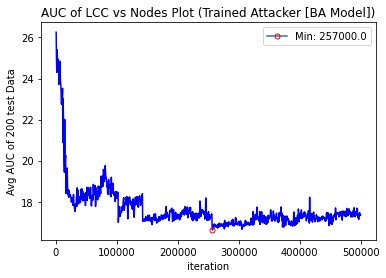

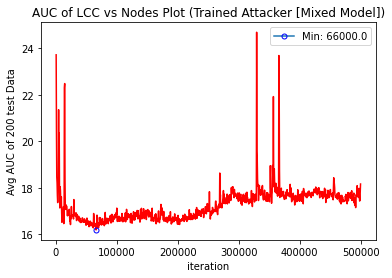

In [10]:
for j in range(2):
    if j == 0:
        color = 'blue'
        inv = 'red'
    else:
        color = 'red'
        inv = 'blue'
    if j == 0:
        name = "(Trained Attacker [BA Model])"
        save = "BA"
        
    else:
        name = "(Trained Attacker [Mixed Model])"
        save = "Diff"                    
    min_vc, min_value = lowest_AUC(results[j,0,:],results[j,1,:])
    plt.plot(results[j,0,:],results[j,1,:], color)
    plt.plot(min_vc, min_value, marker="o", markersize=5, markeredgecolor=inv, markerfacecolor="None",label="Min: "+str(min_vc))
    plt.title("AUC of LCC vs Nodes Plot "+""+str(name)) 
    plt.xlabel("iteration")
    plt.ylabel("Avg AUC of 200 test Data")
    plt.legend()
    plt.savefig("./Cross_Validation/Validation/Test_200_"+save)
    plt.show()
        

(100, 6)


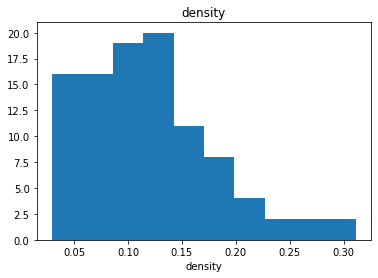

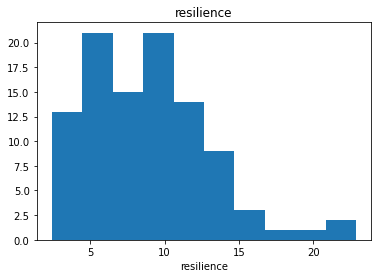

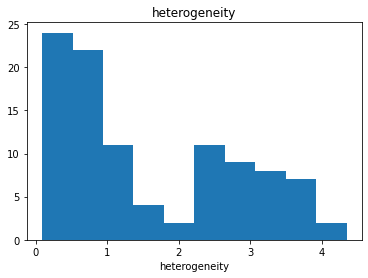

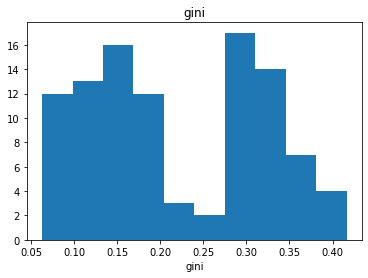

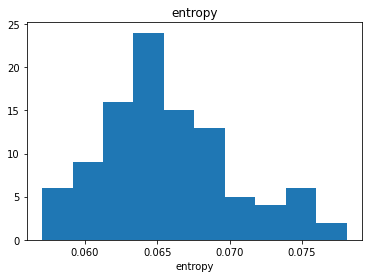

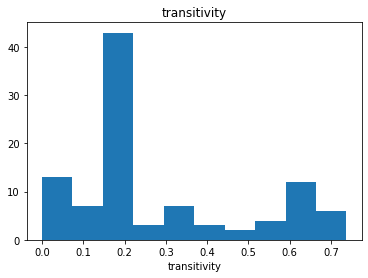

In [11]:
def globalfeature(g): 
    subGraph = g
    M = len(subGraph.edges())
    N = len(subGraph)
    degs =   np.array(subGraph.degree())[:,1]
    k1 = degs.mean()
    k2 = np.mean(degs** 2)
    div = k2 - k1**2
    if k1 != 0:
        heterogeneity = div/k1
        density = (2*M)/(N*(N-1))
        resilience = k2/k1
        sorted_degs = sorted(degs)
        gini = sum([(i+1) * sorted_degs[i] for i in range(N)])/(M*N) - (N+1)/N
        entrop = entropy(degs/M)/N
        transitivity = nx.algorithms.cluster.transitivity(subGraph)
    else:
        heterogeneity = 0
        density = (2*M)/(N*(N-1))
        resilience = 0
        gini = 0
        entrop = 0
        transitivity = nx.algorithms.cluster.transitivity(subGraph)
    global_properties = np.hstack((density,resilience,heterogeneity,gini,entrop,transitivity))
    #global_properties = np.hstack((density,resilience,heterogeneity))
    return global_properties
feature = []
for g in evaluation:
    feature.append(globalfeature(g))
feature = np.array(feature)
print(feature.shape)
label = ['density','resilience','heterogeneity','gini','entropy','transitivity']
for i in range(feature.shape[1]):
    plt.hist(feature[:,i])
    plt.title(label[i])
    plt.xlabel(label[i])
    plt.savefig("./Cross_Validation/Validation/Histogram_200_"+label[i])
    plt.show()

In [12]:
x, value = results[0,0,:],results[0,1,:]
print(x[np.argsort(value)])

[257000. 305500. 276500. 257500. 259000. 265500. 258500. 256500. 263500.
 374000. 372000. 263000. 264000. 278500. 269000. 306500. 283000. 267000.
 269500. 306000. 273500. 309000. 261000. 259500. 388500. 292500. 275000.
 264500. 271000. 273000. 302000. 281000. 262500. 392000. 270500. 274000.
 278000. 448000. 307000. 291000. 260500. 261500. 266000. 312000. 275500.
 377000. 268000. 385500. 267500. 311500. 307500. 318000. 317000. 298500.
 271500. 265000. 301500. 322500. 292000. 387500. 293500. 258000. 324500.
 308500. 298000. 262000. 309500. 289500. 285500. 158000. 389500. 320000.
 314000. 319000. 274500. 382500. 305000. 345500. 453000. 335000. 286500.
 308000. 295500. 345000. 394500. 270000. 277500. 319500. 291500. 313500.
 310000. 389000. 272000. 266500. 293000. 286000. 297500. 285000. 260000.
 450000. 318500. 272500. 279500. 299000. 310500. 314500. 287000. 294000.
 316500. 343000. 289000. 396000. 384500. 297000. 287500. 317500. 313000.
 280000. 276000. 165500. 268500. 416000. 325000. 37

In [13]:
x, value = results[1,0,:],results[1,1,:]
print(x[np.argsort(value)])

[ 66000.  61500.  68000.  70000.  66500.  67000.  54500.  60000.  55500.
  63500.  60500.  64000.  65000.  79500.  64500.  71000.  69500.  49500.
  58000.  75000.  58500.  74000.  24000.  77500. 203000.  63000.  50000.
  51500. 199500.  68500.  80000. 189500.  82000.  52500. 201000. 202000.
 164500. 200000.  86000.  61000.  13000.  59000.  65500.  70500.  53500.
  57000. 125000.  80500.  78000.  90500.  59500.  75500.  13500. 190500.
  81500. 170000. 122500. 183000.  49000. 199000.  41000.  78500.  83500.
  55000.  69000.  83000.  10000.  40000.  50500.  57500.  45500.  46500.
  42500. 138000.  48500.  79000.  52000.  85500. 190000.  56000.  47500.
  93500. 114500. 193500.  45000. 167000. 110500. 109500. 165500. 210500.
 101000. 215000. 180500.  54000.  44500. 105000. 160500. 177500.  72000.
 111500.  56500.  42000. 181500.  38000. 184000. 205500.  87000.  23000.
  53000. 198500. 156500. 102000. 207000.  41500. 159000. 103000.  74500.
  39000. 108000. 194500.  84500. 187000. 158500.  3